In [1]:
%load_ext autoreload

In [2]:
%load_ext jupyter_black

In [3]:
%autoreload 2

In [4]:
import warnings

warnings.filterwarnings("ignore")

In [5]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# The GPU id to use, "0" to  "7"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [6]:
# Import Print function
from __future__ import print_function

In [7]:
# Add manual seed for deterministic results
import torch

torch.manual_seed(1)

# Set Constant Values
batch_size = 128
ricap_beta = 0.4
class_map = {
    "PLANE": 0,
    "CAR": 1,
    "BIRD": 2,
    "CAT": 3,
    "DEER": 4,
    "DOG": 5,
    "FROG": 6,
    "HORSE": 7,
    "SHIP": 8,
    "TRUCK": 9,
}

# Enable or disable visualizations
show_summary = True
show_dataset_analyze = True

In [8]:
from woolly.utils.utils import get_device

# Check GPU availability
use_cuda, device = get_device()

In [68]:
# Load test and train loaders
from woolly.dataset.cifar.dataset import get_cifar_loader, get_advance_cifar_loader

# Get transform functions
from woolly.utils.transform import BASE_PROFILE, get_transform

import json

train_profile = {
    "normalize": BASE_PROFILE["normalize"],
    "shift_scale_rotate": BASE_PROFILE["shift_scale_rotate"],
    # "pad_and_crop": BASE_PROFILE["pad_and_crop"],
    #     'crop_and_pad': BASE_PROFILE['crop_and_pad'],
    # "random_brightness_contrast": BASE_PROFILE["random_brightness_contrast"],
    "horizontal_flip": BASE_PROFILE["horizontal_flip"],
    # "to_gray": BASE_PROFILE["to_gray"],
    "coarse_dropout": BASE_PROFILE["coarse_dropout"],
    "to_tensor": BASE_PROFILE["to_tensor"],
}

# train_profile["pad_and_crop"]["pad"] = 4
# train_profile["pad_and_crop"]["p"] = 0.5

train_profile["coarse_dropout"]["min_height"] = 8
train_profile["coarse_dropout"]["min_width"] = 8
train_profile["coarse_dropout"]["max_height"] = 16
train_profile["coarse_dropout"]["max_width"] = 16
train_profile["coarse_dropout"]["p"] = 0.3

normalize = {
    "normalize": BASE_PROFILE["normalize"],
    "to_tensor": BASE_PROFILE["to_tensor"],
}

course_dropout = {
    "coarse_dropout": BASE_PROFILE["coarse_dropout"],
}

ricap_profile = {"p": 0.3, "ricap_beta": ricap_beta}

# course_dropout['coarse_dropout']['min_height'] = 8
# course_dropout['coarse_dropout']['min_width'] = 8

print("Train Profile:", json.dumps(train_profile, indent=4))
print("Normalize Profile:", json.dumps(normalize, indent=4))
print("Course Dropout Profile:", json.dumps(course_dropout, indent=4))
print("Ricap Profile:", json.dumps(ricap_profile, indent=4))

# # Create train and test loaders with transforms
# train_loader, test_loader = get_advance_cifar_loader(
#     base_transform=get_transform(train_profile),
#     normalize=get_transform(normalize),
# #     apply_ricap=ricap_profile,
# #     apply_cutout=get_transform(course_dropout),
#     batch_size=batch_size,
#     use_cuda=use_cuda
# )

train_loader, test_loader = get_cifar_loader(
    get_transform(train_profile),
    get_transform(normalize),
    batch_size=batch_size,
    use_cuda=use_cuda,
)

Train Profile: {
    "normalize": {
        "mean": [
            0.4914,
            0.4822,
            0.4465
        ],
        "std": [
            0.247,
            0.2435,
            0.2616
        ]
    },
    "shift_scale_rotate": {
        "shift_limit": 0.15,
        "scale_limit": 0.15,
        "rotate_limit": 10,
        "p": 0.3
    },
    "horizontal_flip": {
        "p": 0.3
    },
    "coarse_dropout": {
        "max_holes": 1,
        "max_height": 16,
        "max_width": 16,
        "min_holes": 1,
        "min_height": 8,
        "min_width": 8,
        "fill_value": [
            0.4914,
            0.4822,
            0.4465
        ],
        "p": 0.3
    },
    "to_tensor": true
}
Normalize Profile: {
    "normalize": {
        "mean": [
            0.4914,
            0.4822,
            0.4465
        ],
        "std": [
            0.247,
            0.2435,
            0.2616
        ]
    },
    "to_tensor": true
}
Course Dropout Profile: {
    "coarse_d

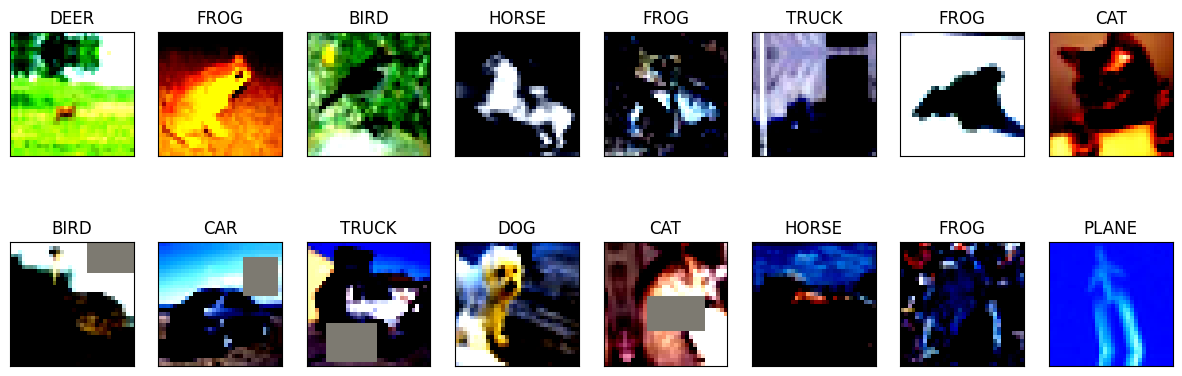

In [69]:
# We will now visualize DataSet by printing data scale and some samples
from woolly.utils.visualize import (
    print_class_scale,
    print_samples,
    print_samples_native,
)

if show_dataset_analyze:
    # print class scale
    #     print_class_scale(train_loader, class_map)
    # print data samples
    # print_samples_native(train_loader, class_map)
    print_samples(train_loader, class_map)

## Load and Train Network

1. Here we will first set all hyper parameters
2. Create moidel instance
3. Print Model summary
4. Run training for all three model techniques

In [75]:
from woolly.models.model import WyCifar10Net
from woolly.bp.vanila.backpropagation import train, test
from woolly.bp.optimizer.backpropagation import get_sgd_optimizer
from woolly.bp.losses.backpropagation import (
    get_crossentropy_criteria,
    get_label_smoothing_criteria,
    get_nnl_criteria,
)
from woolly.utils.utils import initialize_weights, print_summary, print_modal_summary
from woolly.scheduler import one_cycle_lr_custom, one_cycle_lr_pt
from woolly.training import Training

import numpy as np
from torch.cuda.amp import GradScaler

# Set Hyper Parameters Train Params
epochs = 30
lr = 0.05
max_lr = 0.5
steps_per_epoch = len(train_loader)
dropout = True
drop_ratio = 0.01
use_l1 = True
lambda_l1 = 1e-7
momentum = 0.9
weight_decay = 0.000125
weight_decay = weight_decay / batch_size

print("Using Device:", device)
print("Epochs:", epochs)
print("Lr:", lr)
print("Max Lr:", max_lr)
print("Batch Size:", batch_size)
print("Dropout:", dropout)
print("Dropout Ratio:", drop_ratio)
print("Momentum:", momentum)
print("Weight Decay:", weight_decay)
print("Use L1:", use_l1)
print("L1 Lambda:", lambda_l1)
print("RICAP Beta", ricap_beta)
print("----------------------------------------------------------------")

trainers = []
for _norm in ["bn"]:
    # Batch Normalization Technique to be used
    norm = _norm  # "bn"  # 'bn', 'gn', 'ln', 'bgn'
    use1x1 = True  # True, False
    ctype = "depthwise_seperable"  # 'vanila', 'depthwise', 'depthwise_seperable'
    base_channels = 16  # Number of channels to start out the network with
    repetations = 2  # Number of layers repetitions per block
    blocks_count = 2  # Number of Blocks in Network
    usedilation = True  # Do you want a dilated kernel for reducing input_size?
    use_skip = True  # Use skip connection per block
    usepool = False  # Do you want to use max-pooling?
    train_function = train
    test_function = test

    if usedilation and usepool:
        raise Exception(
            "Both Dilation and MaxPooling can not be true at the same time as both are used for reducing input size"
        )

    print("Using Normalization:", norm)
    print("Using 1*1 Skip Connection:", use1x1 and use_skip)
    print("Convolution Type:", ctype)
    print("Number of Blocks:", blocks_count + 1)
    print("Number of Layers Per Block:", repetations * 3)
    print("Use Dilation:", usedilation)
    print("----------------------------------------------------------------")

    # Create an instance of the train function which uses cutout augmented images
    ctrain = train_function(use_l1=use_l1, lambda_l1=lambda_l1)

    # Create a model instance based on a parameter which one to use
    model = (
        WyCifar10Net(
            image=(32, 32),
            ctype=ctype,
            norm=norm,
            use1x1=use1x1,
            base_channels=base_channels,
            layers=repetations,
            drop_ratio=drop_ratio,
            usedilation=usedilation,
            use_skip=use_skip,
            blocks_count=blocks_count,
            usepool=usepool,
        )
        # .apply(initialize_weights)
        .to(device)
    )

    # Create an optimizer instance based on hyperparameters
    optimizer = get_sgd_optimizer(
        model, lr=lr, momentum=momentum, weight_decay=weight_decay
    )
    criteria = get_crossentropy_criteria(device)

    # criteria = get_nnl_criteria(device)

    scaler = GradScaler()

    lrschedule = np.interp(
        np.arange(epochs + 1), [0, 4, 18, epochs], [max_lr / 5.0, max_lr, lr, 0]
    )
    mschedule = np.interp(np.arange(epochs + 1), [0, 4, epochs], [0.95, 0.85, 0.95])

    # Create Custom One Cycle schedule instance
    custom_scheduler = one_cycle_lr_custom(
        optimizer,
        lr=lr,
        max_lr=max_lr,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        lrschedule=lrschedule,
        mschedule=mschedule,
    )

    # custom_scheduler = one_cycle_lr_pt(
    #     optimizer, lr, max_lr, steps_per_epoch, epochs, anneal_strategy="linear"
    # )

    # Create an instance of the trainer with all params
    trainer = Training(
        model,
        optimizer,
        criteria,
        custom_scheduler,
        ctrain,
        test_function,
        train_loader,
        test_loader,
        lr,
        epochs,
        device,
        dropout,
        scaler,
        best_perc=0.80,
    )

    if show_summary:
        # print(model)
        # print_modal_summary(model)
        print_summary(model, input_size=(3, 32, 32))

    trainers.append(trainer)

    # Run trainer
    trainer.run()

Using Device: cuda
Epochs: 30
Lr: 0.05
Max Lr: 0.5
Batch Size: 128
Dropout: True
Dropout Ratio: 0.01
Momentum: 0.9
Weight Decay: 9.765625e-07
Use L1: True
L1 Lambda: 1e-07
RICAP Beta 0.4
----------------------------------------------------------------
Using Normalization: bn
Using 1*1 Skip Connection: True
Convolution Type: depthwise_seperable
Number of Blocks: 3
Number of Layers Per Block: 6
Use Dilation: True
----------------------------------------------------------------
Pading: 0 Sride: 1 Dilation: (1, 1)
Pading: 1 Sride: 1 Dilation: 1
KernelSize: 3
OutputHeight: 32.0 OutputWidth: 32.0
Dilation (9, 9)
Pading: 0 Sride: 2 Dilation: (9, 9)
Pading: 1 Sride: 1 Dilation: 1
Height: 16.0 Width: 16.0
KernelSize: 19
OutputHeight: 16.0 OutputWidth: 16.0
Dilation (5, 5)
Pading: 0 Sride: 2 Dilation: (5, 5)
Pading: 1 Sride: 1 Dilation: 1
Height: 8.0 Width: 8.0
KernelSize: 11
OutputHeight: 8.0 OutputWidth: 8.0
----------------------------------------------------------------
        Layer (type) 

## Analyze Network

We will print comparison between train and test accuries and incorrect predictions

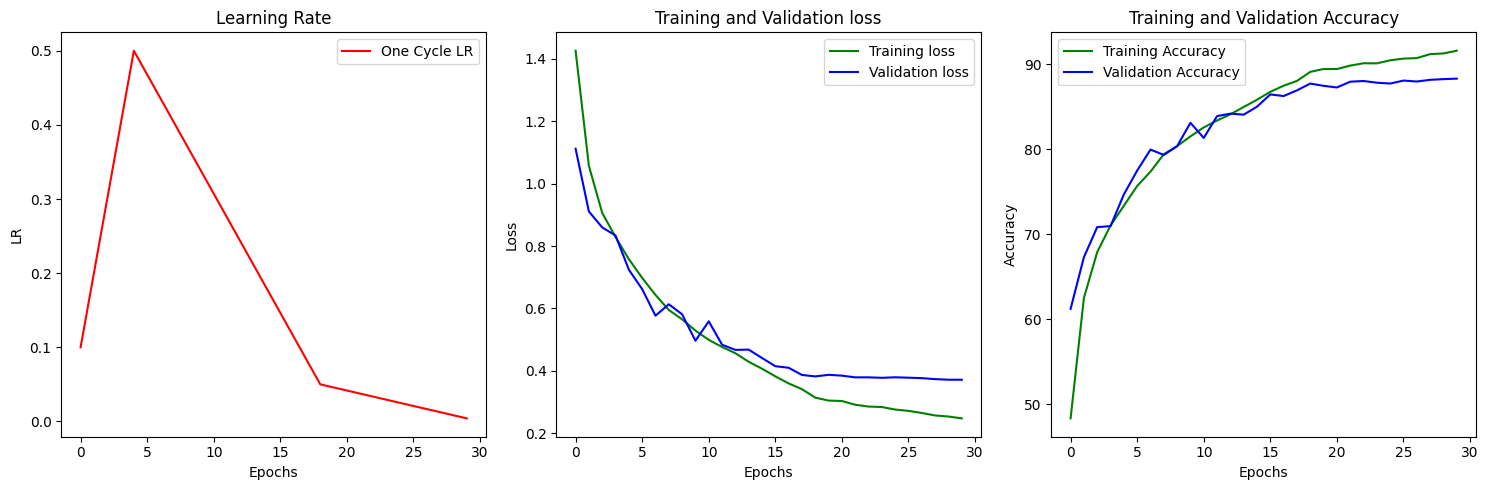

Normalized confusion matrix


Total Incorrect Predictions 1170


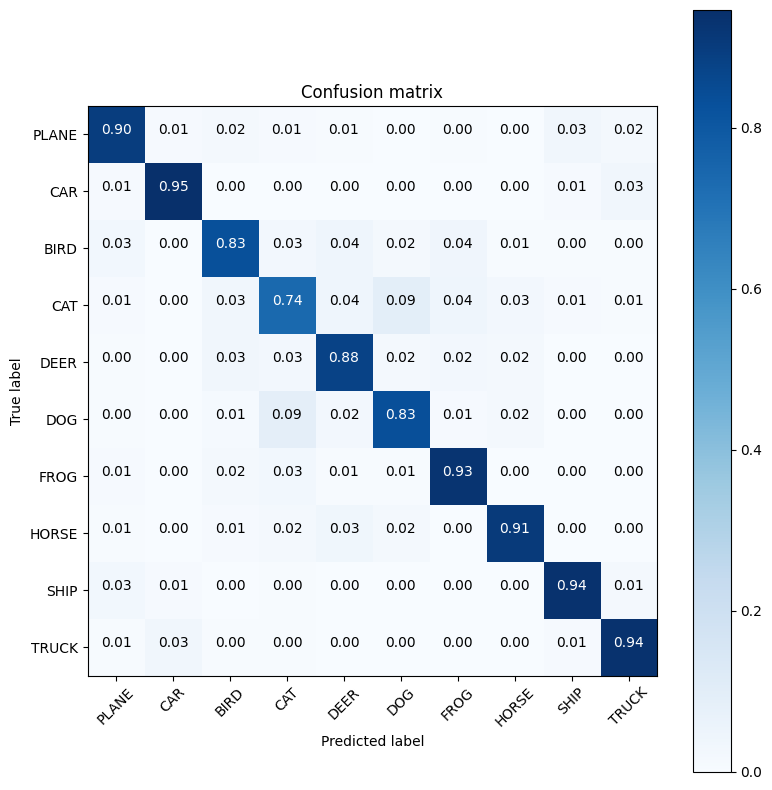

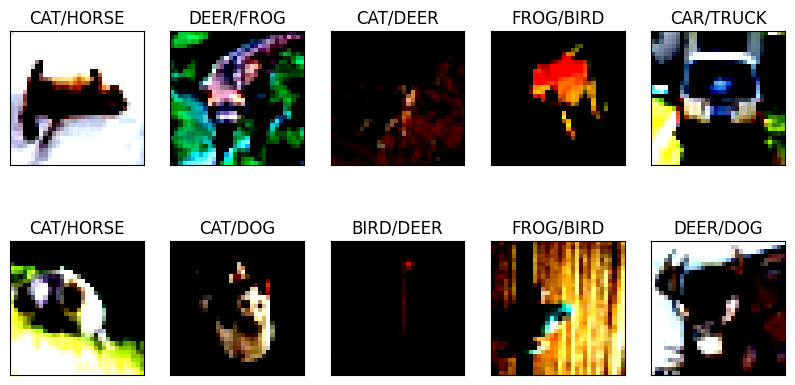

In [76]:
# Visualize network performance

from woolly.utils.visualize import plot_network_performance
from woolly.utils.utils import get_incorrrect_predictions
from woolly.utils.visualize import plot_incorrect_predictions

from woolly.utils.utils import (
    get_all_predictions,
    get_incorrrect_predictions,
    prepare_confusion_matrix,
)
from woolly.utils.visualize import plot_confusion_matrix

plot_network_performance(
    epochs,
    trainer.schedule,
    trainer.list_train_loss,
    trainer.list_valid_loss,
    trainer.list_train_correct,
    trainer.list_valid_correct,
)

all_preds, all_targets = get_all_predictions(trainer.model, test_loader, device)
confusion_matrix = prepare_confusion_matrix(all_preds, all_targets, class_map)
plot_confusion_matrix(confusion_matrix, class_map, normalize=True)

incorrect = get_incorrrect_predictions(trainer.model, test_loader, device)
plot_incorrect_predictions(incorrect, class_map)

## Grad Cam

Here we will implement gradcam on different images

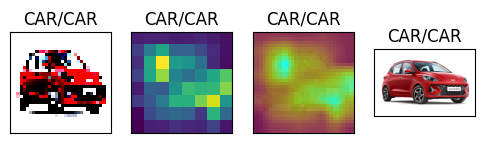

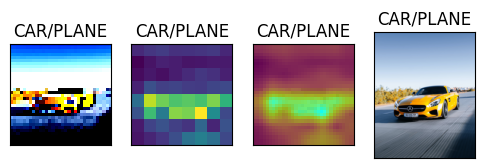

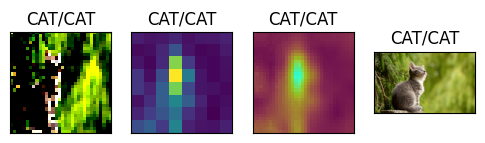

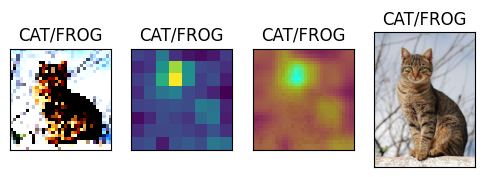

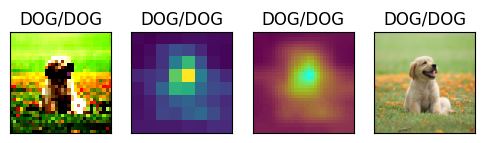

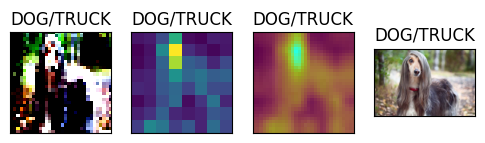

In [77]:
from woolly.utils.gradcam.compute import compute_gradcam

from torch.utils import data

from woolly.dataset.cifar.dataset import WyCustomDataset

transform = get_transform(
    {
        "resize": BASE_PROFILE["resize"],
        "normalize": BASE_PROFILE["normalize"],
        "to_tensor": BASE_PROFILE["to_tensor"],
    }
)

# define an image dataset
dataset = WyCustomDataset(class_map=class_map, path="./data", transforms=transform)

# define the data loader to load that single image
dataloader = data.DataLoader(dataset=dataset, shuffle=False, batch_size=1)

# Compute for all
for img, label, (impath,) in dataloader:
    compute_gradcam(
        trainer.model, class_map, img, impath, label, channel_size=32, device=device
    )

In [78]:
# from torchviz import make_dot

# y = model(img.to(device))
# make_dot(y.mean(), params=dict(model.named_parameters()))

In [79]:
import torch

torch.onnx.export(
    model, img.to(device), "model.onnx", input_names=["image"], output_names=["classes"]
)

============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

